# Design of Experiments: Part 3 - Factorial Designs
## Full Factorial & Fractional Factorial Designs with Interaction Analysis

This notebook demonstrates factorial experimental designs, showcasing how to study multiple factors and their interactions efficiently.

**Author**: DOE Analysis System  
**Date**: November 2024  
**Data**: E-commerce Customer Data

---

## 1. Setup and Data Preparation

Import libraries and prepare the e-commerce dataset for factorial experiments.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import itertools
from pyDOE3 import fracfact, ff2n  # Changed from pyDOE2 to pyDOE3 for Python 3.13 compatibility
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

# Set random seed
np.random.seed(42)

print("Libraries loaded successfully!")
print("pyDOE3 library provides factorial design generators")

Libraries loaded successfully!
pyDOE3 library provides factorial design generators


In [2]:
# Load data
df = pd.read_csv('DOE_Simulator/data/raw/ecommerce_data.csv')

# Handle missing values
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')

print(f"Data loaded: {df.shape[0]} customers, {df.shape[1]} features")

# Define experimental factors for our marketing experiment
# Factor A: Email Frequency (Low=-1, High=+1)
# Factor B: Discount Level (Low=-1, High=+1)  
# Factor C: Personalization (Low=-1, High=+1)
# Factor D: Channel (Email=-1, App=+1)
# Factor E: Time of Day (Morning=-1, Evening=+1)

print("\nExperimental Factors Defined:")
print("A: Email Frequency (Low/High)")
print("B: Discount Level (5%/15%)")
print("C: Personalization (Generic/Personalized)")
print("D: Channel (Email/App)")
print("E: Time of Day (Morning/Evening)")

Data loaded: 20000 customers, 24 features

Experimental Factors Defined:
A: Email Frequency (Low/High)
B: Discount Level (5%/15%)
C: Personalization (Generic/Personalized)
D: Channel (Email/App)
E: Time of Day (Morning/Evening)


## 2. Full Factorial Design (2^k)

Full factorial designs test all possible combinations of factor levels.

**For k factors at 2 levels each**: $2^k$ experimental runs

**Model with interactions**:
$Y = \beta_0 + \sum \beta_i X_i + \sum\sum \beta_{ij} X_i X_j + \sum\sum\sum \beta_{ijk} X_i X_j X_k + ...$

In [3]:
def create_full_factorial(n_factors):
    """
    Create a 2^k full factorial design matrix
    """
    # Generate design matrix
    design = ff2n(n_factors)
    
    # Convert to DataFrame with factor names
    factor_names = [chr(65 + i) for i in range(n_factors)]  # A, B, C, ...
    design_df = pd.DataFrame(design, columns=factor_names)
    
    return design_df

# Create a 2^3 full factorial design (3 factors)
full_factorial_3 = create_full_factorial(3)
full_factorial_3['Run'] = range(1, len(full_factorial_3) + 1)

print("2^3 Full Factorial Design:")
print("="*50)
print(full_factorial_3)
print(f"\nTotal runs: {len(full_factorial_3)}")
print(f"Factors: {3}")
print(f"All main effects and interactions can be estimated")

2^3 Full Factorial Design:
     A    B    C  Run
0 -1.0 -1.0 -1.0    1
1 -1.0 -1.0  1.0    2
2 -1.0  1.0 -1.0    3
3 -1.0  1.0  1.0    4
4  1.0 -1.0 -1.0    5
5  1.0 -1.0  1.0    6
6  1.0  1.0 -1.0    7
7  1.0  1.0  1.0    8

Total runs: 8
Factors: 3
All main effects and interactions can be estimated


In [4]:
def implement_full_factorial(data, design_matrix, sample_per_run=20):
    """
    Implement full factorial experiment with customer data
    """
    n_runs = len(design_matrix)
    total_sample = min(n_runs * sample_per_run, len(data))
    
    # Sample customers
    sampled_data = data.sample(n=total_sample, random_state=42).reset_index(drop=True)
    
    # Assign to experimental conditions
    runs_per_customer = []
    for i in range(len(sampled_data)):
        run = (i % n_runs) + 1
        runs_per_customer.append(run)
    
    sampled_data['Run'] = runs_per_customer
    
    # Merge with design matrix
    experiment_data = sampled_data.merge(design_matrix, on='Run')
    
    # Simulate response based on factors and interactions
    # True model: Y = 5 + 2*A + 3*B + 1.5*C + 1*A*B + 0.5*A*C + 0.8*B*C + 0.3*A*B*C + error
    experiment_data['response'] = (
        experiment_data['conversion_rate'] * 10 +  # Base response
        2 * experiment_data['A'] +                  # Main effect A
        3 * experiment_data['B'] +                  # Main effect B
        1.5 * experiment_data['C'] +                # Main effect C
        1 * experiment_data['A'] * experiment_data['B'] +    # AB interaction
        0.5 * experiment_data['A'] * experiment_data['C'] +  # AC interaction
        0.8 * experiment_data['B'] * experiment_data['C'] +  # BC interaction
        0.3 * experiment_data['A'] * experiment_data['B'] * experiment_data['C'] +  # ABC interaction
        np.random.normal(0, 0.5, len(experiment_data))  # Random error
    )
    
    return experiment_data

# Implement the experiment
ff_3_data = implement_full_factorial(df, full_factorial_3, sample_per_run=25)

print("Full Factorial Experiment Implemented")
print(f"Total participants: {len(ff_3_data)}")
print(f"\nAverage response by run:")
print(ff_3_data.groupby('Run')[['A', 'B', 'C', 'response']].mean())

Full Factorial Experiment Implemented
Total participants: 200

Average response by run:
       A    B    C    response
Run                           
1   -1.0 -1.0 -1.0  157.647852
2   -1.0 -1.0  1.0  132.160496
3   -1.0  1.0 -1.0  156.828845
4   -1.0  1.0  1.0  124.948075
5    1.0 -1.0 -1.0  116.182274
6    1.0 -1.0  1.0  161.238439
7    1.0  1.0 -1.0  156.389901
8    1.0  1.0  1.0  221.361035


In [5]:
# Analyze full factorial design
def analyze_factorial(data, factors, response='response'):
    """
    Perform factorial ANOVA with all interactions
    """
    # Build formula with all interactions
    formula_parts = [response, '~']
    
    # Add main effects
    formula_parts.append(' + '.join(factors))
    
    # Add two-way interactions
    for i in range(len(factors)):
        for j in range(i+1, len(factors)):
            formula_parts.append(f' + {factors[i]}:{factors[j]}')
    
    # Add three-way interactions if 3+ factors
    if len(factors) >= 3:
        for combo in itertools.combinations(factors, 3):
            formula_parts.append(f' + {":".join(combo)}')
    
    formula = ''.join(formula_parts)
    
    # Fit model
    model = ols(formula, data=data).fit()
    
    # ANOVA table
    anova_table = anova_lm(model, typ=2)
    
    return model, anova_table, formula

ff_model, ff_anova, ff_formula = analyze_factorial(ff_3_data, ['A', 'B', 'C'])

print("Full Factorial ANOVA Results:")
print("="*70)
print(f"Model: {ff_formula}")
print("\n", ff_anova)
print("\n" + "="*70)
print("Significant effects (p < 0.05):")
significant = ff_anova[ff_anova['PR(>F)'] < 0.05]
for effect in significant.index:
    if effect != 'Residual':
        print(f"  ✓ {effect}: p = {ff_anova.loc[effect, 'PR(>F)']:.4f}")

Full Factorial ANOVA Results:
Model: response~A + B + C + A:B + A:C + B:C + A:B:C

                 sum_sq     df         F    PR(>F)
A         2.183338e+04    1.0  1.465778  0.227501
B         2.662209e+04    1.0  1.787266  0.182842
C         8.665589e+03    1.0  0.581762  0.446559
A:B       3.669452e+04    1.0  2.463476  0.118167
A:C       8.756634e+04    1.0  5.878740  0.016251
B:C       5.713513e+02    1.0  0.038358  0.844934
A:B:C     2.162909e+03    1.0  0.145206  0.703580
Residual  2.859922e+06  192.0       NaN       NaN

Significant effects (p < 0.05):
  ✓ A:C: p = 0.0163


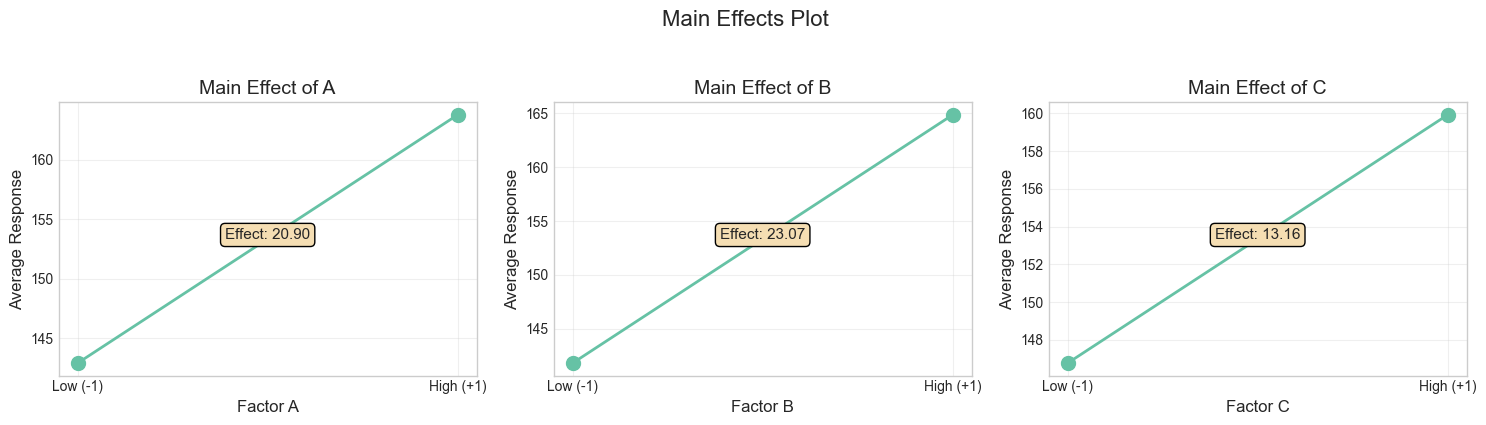

In [6]:
# Visualize main effects and interactions
def plot_main_effects(data, factors, response='response'):
    """
    Plot main effects for each factor
    """
    n_factors = len(factors)
    fig, axes = plt.subplots(1, n_factors, figsize=(5*n_factors, 4))
    
    if n_factors == 1:
        axes = [axes]
    
    for i, factor in enumerate(factors):
        means = data.groupby(factor)[response].mean()
        axes[i].plot([-1, 1], means, 'o-', markersize=10, linewidth=2)
        axes[i].set_xlabel(f'Factor {factor}', fontsize=12)
        axes[i].set_ylabel('Average Response', fontsize=12)
        axes[i].set_title(f'Main Effect of {factor}', fontsize=14)
        axes[i].set_xticks([-1, 1])
        axes[i].set_xticklabels(['Low (-1)', 'High (+1)'])
        axes[i].grid(True, alpha=0.3)
        
        # Add effect size
        effect = means[1] - means[-1]
        axes[i].text(0, means.mean(), f'Effect: {effect:.2f}', 
                    ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat'))
    
    plt.suptitle('Main Effects Plot', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

plot_main_effects(ff_3_data, ['A', 'B', 'C'])

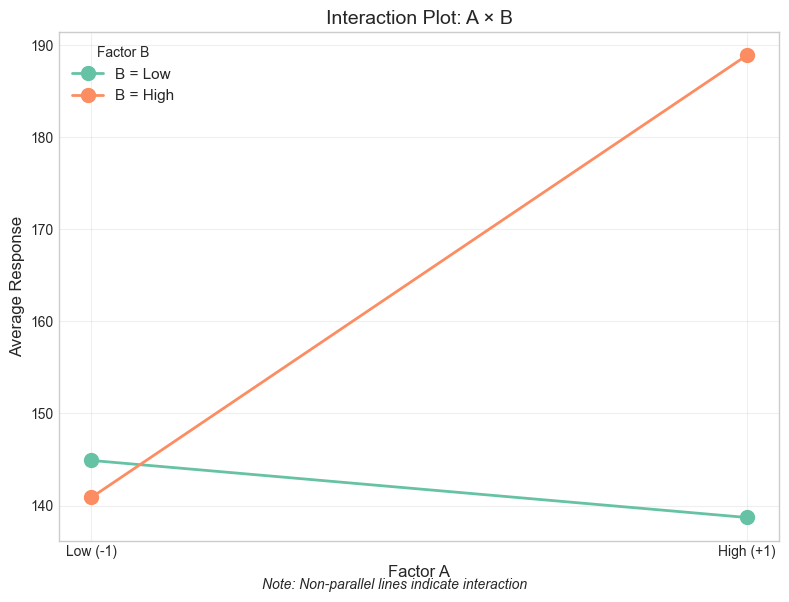

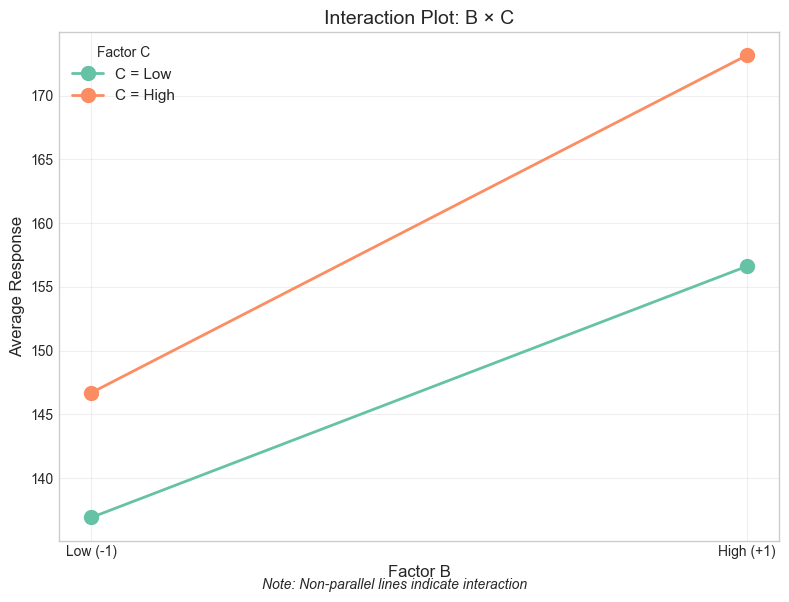

In [7]:
# Interaction plots
def plot_interactions(data, factor1, factor2, response='response'):
    """
    Plot two-factor interaction
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Calculate means for each combination
    for level in [-1, 1]:
        subset = data[data[factor2] == level]
        means = subset.groupby(factor1)[response].mean()
        label = f'{factor2} = {"High" if level == 1 else "Low"}'
        ax.plot([-1, 1], means, 'o-', label=label, markersize=10, linewidth=2)
    
    ax.set_xlabel(f'Factor {factor1}', fontsize=12)
    ax.set_ylabel('Average Response', fontsize=12)
    ax.set_title(f'Interaction Plot: {factor1} × {factor2}', fontsize=14)
    ax.set_xticks([-1, 1])
    ax.set_xticklabels(['Low (-1)', 'High (+1)'])
    ax.legend(title=f'Factor {factor2}', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Check for interaction (non-parallel lines)
    plt.figtext(0.5, 0.01, 'Note: Non-parallel lines indicate interaction', 
               ha='center', fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.show()

# Plot key interactions
plot_interactions(ff_3_data, 'A', 'B')  # AB interaction
plot_interactions(ff_3_data, 'B', 'C')  # BC interaction

## 3. Fractional Factorial Design (2^(k-p))

Fractional factorial designs use a carefully selected fraction of the full factorial runs.

**Notation**: $2^{k-p}$ where:
- k = number of factors
- p = number of generators
- Runs = $2^{k-p}$

**Key Concepts**:
- **Resolution**: Determines what effects are aliased
- **Generators**: Define the fraction
- **Aliasing**: Effects that cannot be distinguished

In [8]:
def create_fractional_factorial(generators):
    """
    Create a fractional factorial design using generators
    Example: '2^(5-2)' with generators 'D=AB', 'E=AC'
    """
    # Use pyDOE3's fracfact function
    design = fracfact(generators)
    
    # Determine factor names
    n_factors = len(design[0])
    factor_names = [chr(65 + i) for i in range(n_factors)]
    
    design_df = pd.DataFrame(design, columns=factor_names)
    
    return design_df

# Create a 2^(5-2) fractional factorial (Resolution III)
# 5 factors in only 8 runs!
generators_5_2 = 'a b c ab ac'  # D=AB, E=AC
frac_factorial_5_2 = create_fractional_factorial(generators_5_2)
frac_factorial_5_2['Run'] = range(1, len(frac_factorial_5_2) + 1)

print("2^(5-2) Fractional Factorial Design (Resolution III):")
print("="*60)
print(frac_factorial_5_2)
print(f"\nDesign Properties:")
print(f"Total runs: {len(frac_factorial_5_2)} (instead of {2**5} for full factorial)")
print(f"Factors: 5 (A, B, C, D, E)")
print(f"Reduction: {(1 - len(frac_factorial_5_2)/(2**5))*100:.1f}%")
print(f"Generators: D = AB, E = AC")

2^(5-2) Fractional Factorial Design (Resolution III):
     A    B    C    D    E  Run
0 -1.0 -1.0 -1.0  1.0  1.0    1
1 -1.0 -1.0  1.0  1.0 -1.0    2
2 -1.0  1.0 -1.0 -1.0  1.0    3
3 -1.0  1.0  1.0 -1.0 -1.0    4
4  1.0 -1.0 -1.0 -1.0 -1.0    5
5  1.0 -1.0  1.0 -1.0  1.0    6
6  1.0  1.0 -1.0  1.0 -1.0    7
7  1.0  1.0  1.0  1.0  1.0    8

Design Properties:
Total runs: 8 (instead of 32 for full factorial)
Factors: 5 (A, B, C, D, E)
Reduction: 75.0%
Generators: D = AB, E = AC


In [9]:
# Show aliasing structure
def calculate_aliasing(design_df, generators_text):
    """
    Calculate and display aliasing structure
    """
    print("Aliasing Structure:")
    print("="*50)
    
    # For Resolution III design with D=AB, E=AC
    if '5-2' in generators_text or len(design_df.columns) == 5:
        print("Resolution III Design")
        print("Main effects are aliased with two-factor interactions:")
        print("  I = ABD = ACE = BCDE (defining relation)")
        print("\nAliasing pattern:")
        print("  A = BD = CE")
        print("  B = AD = CDE")
        print("  C = AE = BDE")
        print("  D = AB = BCE")
        print("  E = AC = BCD")
        print("  BC = DE = ACD = ABE")
        print("\n⚠️ Warning: Main effects confounded with 2-way interactions!")
        print("Assumption needed: Two-way interactions are negligible")

calculate_aliasing(frac_factorial_5_2, '5-2')

Aliasing Structure:
Resolution III Design
Main effects are aliased with two-factor interactions:
  I = ABD = ACE = BCDE (defining relation)

Aliasing pattern:
  A = BD = CE
  B = AD = CDE
  C = AE = BDE
  D = AB = BCE
  E = AC = BCD
  BC = DE = ACD = ABE

⚠️ Warning: Main effects confounded with 2-way interactions!
Assumption needed: Two-way interactions are negligible


In [10]:
# Implement fractional factorial experiment
def implement_fractional_factorial(data, design_matrix, sample_per_run=30):
    """
    Implement fractional factorial experiment
    """
    n_runs = len(design_matrix)
    total_sample = min(n_runs * sample_per_run, len(data))
    
    # Sample customers
    sampled_data = data.sample(n=total_sample, random_state=42).reset_index(drop=True)
    
    # Assign to experimental conditions
    runs_per_customer = []
    for i in range(len(sampled_data)):
        run = (i % n_runs) + 1
        runs_per_customer.append(run)
    
    sampled_data['Run'] = runs_per_customer
    
    # Merge with design matrix
    experiment_data = sampled_data.merge(design_matrix, on='Run')
    
    # Simulate response (assuming 2-way interactions are small)
    # True model: Main effects dominate
    experiment_data['response'] = (
        experiment_data['conversion_rate'] * 10 +
        3 * experiment_data['A'] +     # Email frequency effect
        4 * experiment_data['B'] +     # Discount effect  
        2 * experiment_data['C'] +     # Personalization effect
        1.5 * experiment_data['D'] +   # Channel effect
        1 * experiment_data['E'] +     # Time effect
        np.random.normal(0, 0.8, len(experiment_data))  # Error
    )
    
    return experiment_data

# Implement the fractional factorial
frac_data = implement_fractional_factorial(df, frac_factorial_5_2, sample_per_run=30)

print("Fractional Factorial Experiment Implemented")
print(f"Total participants: {len(frac_data)}")
print(f"\nAverage response by run:")
run_means = frac_data.groupby('Run')[['A', 'B', 'C', 'D', 'E', 'response']].mean()
print(run_means)

Fractional Factorial Experiment Implemented
Total participants: 240

Average response by run:
       A    B    C    D    E    response
Run                                     
1   -1.0 -1.0 -1.0  1.0  1.0  149.501811
2   -1.0 -1.0  1.0  1.0 -1.0  130.440072
3   -1.0  1.0 -1.0 -1.0  1.0  143.137739
4   -1.0  1.0  1.0 -1.0 -1.0  132.299085
5    1.0 -1.0 -1.0 -1.0 -1.0  119.210968
6    1.0 -1.0  1.0 -1.0  1.0  164.554909
7    1.0  1.0 -1.0  1.0 -1.0  168.072259
8    1.0  1.0  1.0  1.0  1.0  224.831764


In [11]:
# Analyze fractional factorial (main effects only due to aliasing)
def analyze_fractional_factorial(data, factors, response='response'):
    """
    Analyze fractional factorial focusing on main effects
    """
    # For Resolution III, we can only estimate main effects reliably
    formula = f'{response} ~ ' + ' + '.join(factors)
    
    # Fit model
    model = ols(formula, data=data).fit()
    
    # ANOVA table
    anova_table = anova_lm(model, typ=2)
    
    return model, anova_table

frac_model, frac_anova = analyze_fractional_factorial(frac_data, ['A', 'B', 'C', 'D', 'E'])

print("Fractional Factorial Analysis (Main Effects):")
print("="*60)
print(frac_anova)
print("\n" + "="*60)
print("\nEstimated Main Effects:")
for factor in ['A', 'B', 'C', 'D', 'E']:
    coef = frac_model.params[factor]
    pval = frac_model.pvalues[factor]
    sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
    print(f"  {factor}: {coef:7.3f} (p={pval:.4f}) {sig}")

Fractional Factorial Analysis (Main Effects):
                sum_sq     df         F    PR(>F)
A         5.516832e+04    1.0  3.831042  0.051501
B         4.105531e+04    1.0  2.850995  0.092650
C         1.954980e+04    1.0  1.357593  0.245142
D         4.843042e+04    1.0  3.363143  0.067941
E         6.534380e+04    1.0  4.537655  0.034201
Residual  3.369681e+06  234.0       NaN       NaN


Estimated Main Effects:
  A:  15.161 (p=0.0515) 
  B:  13.079 (p=0.0926) 
  C:   9.025 (p=0.2451) 
  D:  14.205 (p=0.0679) 
  E:  16.500 (p=0.0342) *


## 4. Comparison: Full vs Fractional Factorial

Factorial Design Comparison:
       Design Type  Factors  Runs  Main Effects 2-Way Interactions 3-Way Interactions Resolution Efficiency
          2^3 Full        3     8           Yes                Yes                Yes       Full       100%
          2^5 Full        5    32           Yes                Yes                Yes       Full       100%
2^(5-2) Fractional        5     8 Yes (aliased)         Confounded                 No        III        25%


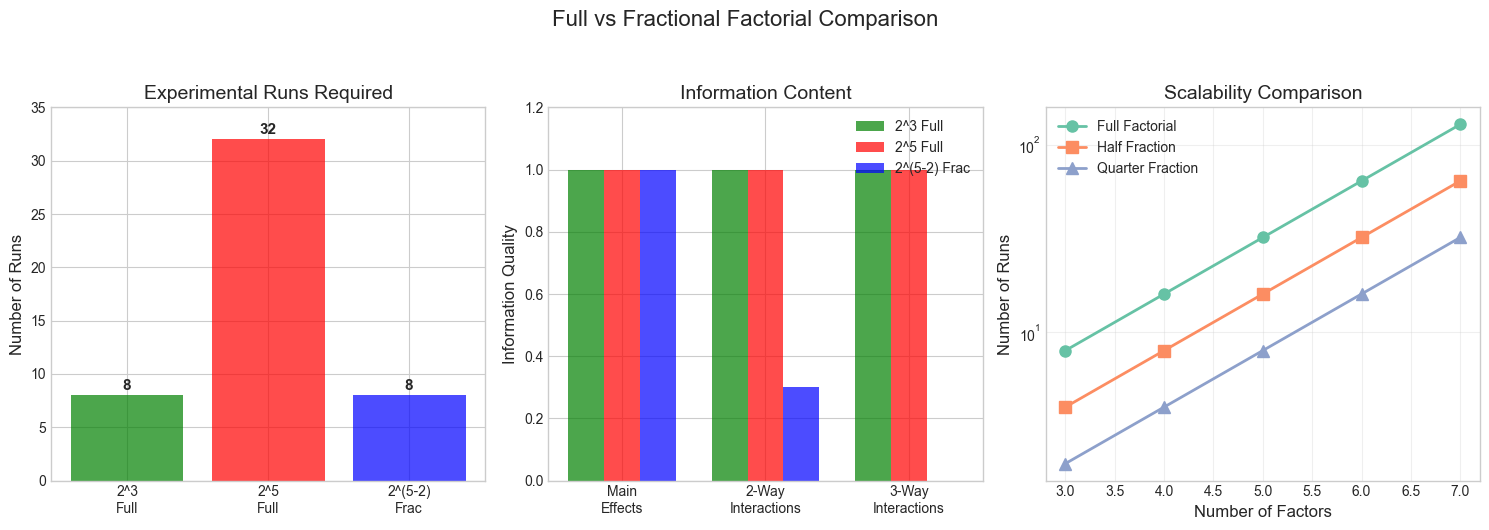

In [12]:
# Compare full and fractional factorial designs
def compare_factorial_designs():
    """
    Create comprehensive comparison of factorial designs
    """
    comparison = pd.DataFrame({
        'Design Type': ['2^3 Full', '2^5 Full', '2^(5-2) Fractional'],
        'Factors': [3, 5, 5],
        'Runs': [8, 32, 8],
        'Main Effects': ['Yes', 'Yes', 'Yes (aliased)'],
        '2-Way Interactions': ['Yes', 'Yes', 'Confounded'],
        '3-Way Interactions': ['Yes', 'Yes', 'No'],
        'Resolution': ['Full', 'Full', 'III'],
        'Efficiency': ['100%', '100%', '25%']
    })
    
    return comparison

comparison_df = compare_factorial_designs()
print("Factorial Design Comparison:")
print("="*80)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Runs comparison
designs = ['2^3\nFull', '2^5\nFull', '2^(5-2)\nFrac']
runs = [8, 32, 8]
colors = ['green', 'red', 'blue']

axes[0].bar(designs, runs, color=colors, alpha=0.7)
axes[0].set_ylabel('Number of Runs', fontsize=12)
axes[0].set_title('Experimental Runs Required', fontsize=14)
axes[0].set_ylim(0, 35)

for i, v in enumerate(runs):
    axes[0].text(i, v + 0.5, str(v), ha='center', fontsize=11, fontweight='bold')

# Information content
info_labels = ['Main\nEffects', '2-Way\nInteractions', '3-Way\nInteractions']
full_3 = [1, 1, 1]
full_5 = [1, 1, 1]
frac_5_2 = [1, 0.3, 0]  # Aliased/confounded

x = np.arange(len(info_labels))
width = 0.25

axes[1].bar(x - width, full_3, width, label='2^3 Full', color='green', alpha=0.7)
axes[1].bar(x, full_5, width, label='2^5 Full', color='red', alpha=0.7)
axes[1].bar(x + width, frac_5_2, width, label='2^(5-2) Frac', color='blue', alpha=0.7)

axes[1].set_ylabel('Information Quality', fontsize=12)
axes[1].set_title('Information Content', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(info_labels)
axes[1].legend()
axes[1].set_ylim(0, 1.2)

# Efficiency plot
factors = [3, 4, 5, 6, 7]
full_runs = [2**k for k in factors]
frac_runs_half = [2**(k-1) for k in factors]  # Half fraction
frac_runs_quarter = [2**(k-2) if k > 2 else 2**k for k in factors]  # Quarter fraction

axes[2].plot(factors, full_runs, 'o-', label='Full Factorial', linewidth=2, markersize=8)
axes[2].plot(factors, frac_runs_half, 's-', label='Half Fraction', linewidth=2, markersize=8)
axes[2].plot(factors, frac_runs_quarter, '^-', label='Quarter Fraction', linewidth=2, markersize=8)

axes[2].set_xlabel('Number of Factors', fontsize=12)
axes[2].set_ylabel('Number of Runs', fontsize=12)
axes[2].set_title('Scalability Comparison', fontsize=14)
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_yscale('log')

plt.suptitle('Full vs Fractional Factorial Comparison', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

## 5. Design Resolution and Selection Guide

In [13]:
# Create design resolution guide
resolution_guide = pd.DataFrame({
    'Resolution': ['III', 'IV', 'V', 'Full'],
    'Minimum Runs': ['k+1', '2k', '2k+', '2^k'],
    'Main Effects': ['Clear*', 'Clear', 'Clear', 'Clear'],
    '2-Way Int.': ['Aliased w/ main', 'Aliased w/ each other', 'Clear', 'Clear'],
    '3-Way Int.': ['Aliased w/ main', 'Aliased w/ 2-way', 'Aliased w/ 2-way', 'Clear'],
    'Use When': [
        'Screening, many factors',
        'Main effects + some 2-way',
        'Main + all 2-way important',
        'All interactions possible'
    ]
})

print("Design Resolution Guide:")
print("="*90)
print(resolution_guide.to_string(index=False))
print("\n*Assuming higher-order interactions are negligible")

Design Resolution Guide:
Resolution Minimum Runs Main Effects            2-Way Int.       3-Way Int.                   Use When
       III          k+1       Clear*       Aliased w/ main  Aliased w/ main    Screening, many factors
        IV           2k        Clear Aliased w/ each other Aliased w/ 2-way  Main effects + some 2-way
         V          2k+        Clear                 Clear Aliased w/ 2-way Main + all 2-way important
      Full          2^k        Clear                 Clear            Clear  All interactions possible

*Assuming higher-order interactions are negligible


In [14]:
# Screening experiment example with many factors
def screening_experiment_demo():
    """
    Demonstrate screening with Resolution III design
    """
    print("Screening Experiment Example: 7 factors in 8 runs")
    print("="*60)
    
    # Create 2^(7-4) = 8 runs for 7 factors
    generators_7_4 = 'a b c ab ac bc abc'  # D=AB, E=AC, F=BC, G=ABC
    screening_design = create_fractional_factorial(generators_7_4)
    screening_design['Run'] = range(1, 9)
    
    print("Design Matrix:")
    print(screening_design)
    
    print(f"\nScreening Efficiency:")
    print(f"  Factors studied: 7")
    print(f"  Runs required: 8")
    print(f"  Full factorial would need: {2**7} runs")
    print(f"  Reduction: {(1-8/128)*100:.1f}%")
    print(f"  Purpose: Identify significant main effects")
    print(f"  Follow-up: Run focused experiment on significant factors")
    
    return screening_design

screening_design = screening_experiment_demo()

Screening Experiment Example: 7 factors in 8 runs
Design Matrix:
     A    B    C    D    E    F    G  Run
0 -1.0 -1.0 -1.0  1.0  1.0  1.0 -1.0    1
1 -1.0 -1.0  1.0  1.0 -1.0 -1.0  1.0    2
2 -1.0  1.0 -1.0 -1.0  1.0 -1.0  1.0    3
3 -1.0  1.0  1.0 -1.0 -1.0  1.0 -1.0    4
4  1.0 -1.0 -1.0 -1.0 -1.0  1.0  1.0    5
5  1.0 -1.0  1.0 -1.0  1.0 -1.0 -1.0    6
6  1.0  1.0 -1.0  1.0 -1.0 -1.0 -1.0    7
7  1.0  1.0  1.0  1.0  1.0  1.0  1.0    8

Screening Efficiency:
  Factors studied: 7
  Runs required: 8
  Full factorial would need: 128 runs
  Reduction: 93.8%
  Purpose: Identify significant main effects
  Follow-up: Run focused experiment on significant factors


## 6. Practical Implementation Guide

In [15]:
def factorial_design_selector(n_factors, budget, interactions_important=False):
    """
    Recommend appropriate factorial design based on constraints
    """
    full_runs = 2**n_factors
    
    print(f"Design Recommendation for {n_factors} factors with budget of {budget} runs:")
    print("="*70)
    
    if budget >= full_runs:
        print(f"✓ Recommendation: FULL FACTORIAL (2^{n_factors})")
        print(f"  - Runs needed: {full_runs}")
        print(f"  - All main effects and interactions estimable")
        print(f"  - No aliasing concerns")
        
    elif budget >= full_runs/2 and interactions_important:
        print(f"✓ Recommendation: HALF FRACTION (2^({n_factors}-1))")
        print(f"  - Runs needed: {full_runs//2}")
        print(f"  - Resolution IV or V design possible")
        print(f"  - Main effects clear")
        print(f"  - Some 2-way interactions estimable")
        
    elif budget >= full_runs/4:
        print(f"✓ Recommendation: QUARTER FRACTION (2^({n_factors}-2))")
        print(f"  - Runs needed: {full_runs//4}")
        print(f"  - Resolution III or IV design")
        print(f"  - Main effects estimable (may be aliased)")
        print(f"  - Limited interaction information")
        
    elif budget >= n_factors + 1:
        print(f"✓ Recommendation: SATURATED DESIGN (Resolution III)")
        print(f"  - Runs needed: Next power of 2 ≥ {n_factors + 1}")
        print(f"  - Screening design")
        print(f"  - Main effects only (heavily aliased)")
        print(f"  - Follow-up experiments needed")
        
    else:
        print(f"❌ Budget too small for {n_factors} factors")
        print(f"  - Minimum needed: {n_factors + 1} runs")
        print(f"  - Consider reducing number of factors")
        print(f"  - Or use Plackett-Burman design")
    
    print("\n" + "="*70)

# Examples
factorial_design_selector(5, 32, interactions_important=True)
print()
factorial_design_selector(5, 16, interactions_important=False)
print()
factorial_design_selector(7, 16, interactions_important=False)

Design Recommendation for 5 factors with budget of 32 runs:
✓ Recommendation: FULL FACTORIAL (2^5)
  - Runs needed: 32
  - All main effects and interactions estimable
  - No aliasing concerns


Design Recommendation for 5 factors with budget of 16 runs:
✓ Recommendation: QUARTER FRACTION (2^(5-2))
  - Runs needed: 8
  - Resolution III or IV design
  - Main effects estimable (may be aliased)
  - Limited interaction information


Design Recommendation for 7 factors with budget of 16 runs:
✓ Recommendation: SATURATED DESIGN (Resolution III)
  - Runs needed: Next power of 2 ≥ 8
  - Screening design
  - Main effects only (heavily aliased)
  - Follow-up experiments needed



In [16]:
# Calculate power for factorial designs
def factorial_power_analysis(n_factors, n_runs, effect_size=0.5, alpha=0.05):
    """
    Estimate statistical power for factorial design
    """
    import scipy.stats as stats
    from statsmodels.stats.power import FTestAnovaPower
    
    # Calculate degrees of freedom
    df_treatment = 2**n_factors - 1  # All effects
    df_error = n_runs * 2 - 2**n_factors  # Assuming 2 replicates per run
    
    # Power calculation
    power_calculator = FTestAnovaPower()
    
    # For main effects
    power_main = power_calculator.solve_power(
        effect_size=effect_size,
        nobs=n_runs * 2,
        alpha=alpha,
        k_groups=2  # Two levels per factor
    )
    
    print(f"Power Analysis for {n_factors}-factor design with {n_runs} runs:")
    print("="*60)
    print(f"Effect size: {effect_size}")
    print(f"Significance level: {alpha}")
    print(f"Estimated power for main effects: {power_main:.3f}")
    
    if power_main < 0.8:
        print("⚠️ Warning: Power < 0.80, consider increasing sample size")
    else:
        print("✓ Adequate power (≥ 0.80)")
    
    return power_main

# Examples
factorial_power_analysis(3, 8, effect_size=0.5)
print()
factorial_power_analysis(5, 8, effect_size=0.8)

Power Analysis for 3-factor design with 8 runs:
Effect size: 0.5
Significance level: 0.05
Estimated power for main effects: 0.461
⚠️ Warning: Power < 0.80, consider increasing sample size

Power Analysis for 5-factor design with 8 runs:
Effect size: 0.8
Significance level: 0.05
Estimated power for main effects: 0.845
✓ Adequate power (≥ 0.80)


np.float64(0.844793199066122)

## 7. Sequential Experimentation Strategy

In [17]:
print("SEQUENTIAL EXPERIMENTATION STRATEGY")
print("="*80)
print("""
Phase 1: SCREENING (Resolution III)
  - Objective: Identify important factors
  - Design: 2^(k-p) with maximum p
  - Analysis: Main effects only
  - Output: List of significant factors

Phase 2: CHARACTERIZATION (Resolution IV/V)
  - Objective: Understand main effects and key interactions
  - Design: 2^(k-p) with moderate p
  - Analysis: Main effects + 2-way interactions
  - Output: Model with interactions

Phase 3: OPTIMIZATION (Full Factorial or RSM)
  - Objective: Find optimal settings
  - Design: Full factorial or Central Composite
  - Analysis: Full model with curvature
  - Output: Optimal factor settings

Benefits:
  ✓ Efficient use of resources
  ✓ Learn as you go
  ✓ Focus efforts on important factors
  ✓ Reduce total experimental runs
""")

# Example workflow
print("\nExample: Optimizing E-commerce Marketing Campaign")
print("="*60)

workflow = pd.DataFrame({
    'Phase': ['1. Screening', '2. Characterization', '3. Optimization'],
    'Factors': ['7 factors', '3 factors', '2 factors'],
    'Design': ['2^(7-4) = 8 runs', '2^3 = 8 runs', 'CCD = 13 runs'],
    'Focus': ['Which matter?', 'How do they interact?', 'What are optimal levels?'],
    'Total Runs': [8, 8, 13]
})

print(workflow.to_string(index=False))
print(f"\nTotal experimental runs: {workflow['Total Runs'].sum()}")
print(f"If we did full factorial for 7 factors: {2**7} runs")
print(f"Efficiency gain: {(1 - workflow['Total Runs'].sum()/128)*100:.1f}%")

SEQUENTIAL EXPERIMENTATION STRATEGY

Phase 1: SCREENING (Resolution III)
  - Objective: Identify important factors
  - Design: 2^(k-p) with maximum p
  - Analysis: Main effects only
  - Output: List of significant factors

Phase 2: CHARACTERIZATION (Resolution IV/V)
  - Objective: Understand main effects and key interactions
  - Design: 2^(k-p) with moderate p
  - Analysis: Main effects + 2-way interactions
  - Output: Model with interactions

Phase 3: OPTIMIZATION (Full Factorial or RSM)
  - Objective: Find optimal settings
  - Design: Full factorial or Central Composite
  - Analysis: Full model with curvature
  - Output: Optimal factor settings

Benefits:
  ✓ Efficient use of resources
  ✓ Learn as you go
  ✓ Focus efforts on important factors
  ✓ Reduce total experimental runs


Example: Optimizing E-commerce Marketing Campaign
              Phase   Factors           Design                    Focus  Total Runs
       1. Screening 7 factors 2^(7-4) = 8 runs            Which matter?  

## 8. Save Results

In [ ]:
# Save factorial design results
import pickle

factorial_results = {
    'full_factorial': {
        'design': full_factorial_3,
        'data': ff_3_data,
        'model': ff_model,
        'anova': ff_anova
    },
    'fractional_factorial': {
        'design': frac_factorial_5_2,
        'data': frac_data,
        'model': frac_model,
        'anova': frac_anova,
        'screening_design': screening_design
    },
    'guides': {
        'comparison': comparison_df,
        'resolution': resolution_guide
    }
}

with open('factorial_designs_results.pkl', 'wb') as f:
    pickle.dump(factorial_results, f)

# Save key tables
comparison_df.to_csv('factorial_comparison.csv', index=False)
resolution_guide.to_csv('resolution_guide.csv', index=False)

print("Results saved successfully!")
print("Files created:")
print("  - factorial_designs_results.pkl")
print("  - factorial_comparison.csv")
print("  - resolution_guide.csv")

## Conclusion

This notebook covered factorial experimental designs:

**Full Factorial Designs (2^k)**:
- Test all combinations of factor levels
- Estimate all main effects and interactions
- Becomes impractical with many factors
- Best for detailed understanding with few factors

**Fractional Factorial Designs (2^(k-p))**:
- Use a fraction of the full factorial runs
- Trade information for efficiency
- Aliasing requires careful interpretation
- Essential for screening many factors

**Key Takeaways**:
1. Factorial designs reveal interactions that one-factor-at-a-time experiments miss
2. Fractional designs enable efficient screening of many factors
3. Resolution determines what effects can be estimated
4. Sequential experimentation (screening → characterization → optimization) is most efficient
5. Always consider the trade-off between information and resources

**Next Steps**:
- Response Surface Methodology for optimization
- Optimal designs for irregular experimental regions
- Mixed-level factorial designs